In [1]:
from crear_dataset import *
from funcions_net import *
import numpy as np
import matplotlib.pyplot as plt
import pyreadstat
import pandas as pd
from preprocessing import *
from sklearn.model_selection import train_test_split
from func_sel import *
from funcions_net import *


In [2]:

df_orig, meta = pyreadstat.read_sav("CEJFEAjut2015Updated.sav")

df_variables = pd.read_csv("variables.csv", sep=';')

dict = create_dict(meta)

df_inicial = dataset_inicial(df_orig, dict)

df_inicial['temps_fins_reincidencia1a'] = df_inicial['temps_fins_reincidencia1a'].apply(lambda x: 1095 if x > 1095 else x)



Creant dataset inicial
Creant dataset origen
(72, 15)
Creant dataset origen
(72, 37)
Delictes comesos
(72, 15)
Dataset final
(72, 15)
Dataset final
(72, 53)


c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\crear_dataset.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_actual['Gitanos'] = np.where(df_anterior['Etnia'] ==1, 1, 0)
c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\crear_dataset.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_actual['Magrebins'] = np.where(df_anterior['Etnia'] ==2, 1, 0)
c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\crear_dataset.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [3]:
print(df_inicial["Violent_o_lesions"].value_counts())

Violent_o_lesions
False    40
True     32
Name: count, dtype: int64


NameError: name 'df_inicial' is not defined

In [35]:
print("Mirem quants nans tenim a cada columna")
netejat,df = neteja_na_columns(df_inicial, llindar=0.6)

df = omple_nans(df)

print("Columnes netejades")
## fem label encoding de les columnes categòriques
df = label_encoding(df)


Mirem quants nans tenim a cada columna
Columnes netejades


c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\preprocessing.py:73: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_net[col].fillna(mitjana, inplace=True)


In [36]:
num_columnes = df.shape[1]
print("Hem netejat les columnes i hem fet label encoding")
print("Tenim ", num_columnes, " columnes")

Hem netejat les columnes i hem fet label encoding
Tenim  53  columnes


In [37]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='temps_fins_reincidencia1a'), df['temps_fins_reincidencia1a'], test_size=0.2,random_state=42)


In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_train = pd.DataFrame(X_train, columns=df.drop(columns='temps_fins_reincidencia1a').columns)

In [39]:
X_train_filtrat, coef_significatius = filter_significant_features(X_train,y_train, df, llindar=0.001,alpha=0.01, print_results=True)

Hem fet el model Lasso
Hem trobat  8  coeficients nuls
Hem trobat  44  coeficients no nuls
Els coeficients no nuls ordenats per valor absolut són:
RAVEN_PD                     592.915048
EdatAD                       369.948574
RAVEN02                     -324.139863
Nord_America                 263.325274
Pri_Ing                     -259.985597
RAVEN05                     -233.261477
RAVEN04                     -181.024593
Homicidi                    -157.926166
Nom_Ing                     -137.682421
Mesos_Internament           -135.500029
Quebrantament de condemna   -125.498998
Magrebins                    125.397025
RAVEN03                     -119.075811
Magreb                      -108.521857
Caucasics                    -99.886917
PCLo05                        90.151566
RAVEN_IQ                      85.315290
Robatori amb violència       -85.191615
CentreEducatiu                82.301718
Llatins                       70.816449
dtype: float64


c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.054e+04, tolerance: 4.958e+02
  model = cd_fast.enet_coordinate_descent(


In [40]:
## ensenyem els coef mes grans

maxims = np.sort(abs(coef_significatius))[::-1]

# Printem els índexs dels coeficients més grans
index_maxims = np.argsort(abs(coef_significatius))[::-1]
print(index_maxims[10:20])

Drogues                         39
Robatori amb violència          16
Robatori                        10
Pares_No_Catalans_Un_Espanya    23
Pares_No_Catalans_Espanya       19
Pare_Catala_Fora_Espanya         3
Pares_Catalans                  14
Nord_America                    32
Centre_Sud_America               0
Resta_Africa                    18
dtype: int64


In [41]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

## fem grid search per trobar els millors hiperparàmetres

param_grid = {
    'n_estimators': [100,250,500],
    'max_depth': [30,40,50],
}

rf = RandomForestRegressor()

grid_search = GridSearchCV(
    rf, 
    param_grid, 
    cv=10, 
    scoring='neg_mean_absolute_error', 
    return_train_score=True
)

# Realitzem el Grid Search
grid_search.fit(X_train_filtrat, y_train)

# Resultats
print("Millor paràmetre:", grid_search.best_params_)
print("Millor precisió:", -grid_search.best_score_)  # Negatiu perquè s'ha usat neg_mean_squared_error

# Mostrem la mitjana dels resultats de test
print("Mitjana dels resultats de test per cada combinació:")
print(np.mean(grid_search.cv_results_['mean_test_score'] * -1))  # Multipliquem per -1 per obtenir el MSE positiu

best_model = grid_search.best_estimator_


Millor paràmetre: {'max_depth': 50, 'n_estimators': 100}
Millor precisió: 238.1927666666667
Mitjana dels resultats de test per cada combinació:
242.56024888888885


In [42]:
# Obtenim la importància de cada característica
coef_importants = best_model.feature_importances_

# Obtenim els noms de les característiques (suposant que tenim un DataFrame 'df')
feature_names = X_train_filtrat.columns  

# Ordenem les característiques segons la seva importància (de major a menor)
indices_ordenats = coef_importants.argsort()[::-1][0:25]

# Mostrem els noms de les 20 característiques més importants amb la seva importància
print("Les 20 característiques més importants són:")
for i in indices_ordenats:
    print(f"{feature_names[i]}: {coef_importants[i]:.4f}")



Les 20 característiques més importants són:
EdatAD: 0.2225
Nom_Exp: 0.1690
Mesos_Internament: 0.1381
RAVEN05: 0.0790
RAVEN04: 0.0582
Delictes molt violents: 0.0298
RAVEN_PD: 0.0278
Pri_Exp: 0.0218
Nord_America: 0.0212
RAVEN03: 0.0198
Lesions: 0.0180
Pare_Catala_Fora_Espanya: 0.0143
Nom_Ing: 0.0142
Pri_Ing: 0.0142
Niv_Esc: 0.0132
Seguretat de l'Estat: 0.0126
Delictes patrimonials: 0.0113
RAVEN02: 0.0098
Resta_Africa: 0.0097
Delictes sexuals: 0.0095
Magreb: 0.0091
Robatori amb violència: 0.0082
PCLo05: 0.0080
Administració de justícia: 0.0075
Llatins: 0.0072



--- AVALUACIÓ FINAL EN TEST ---
MSE (Test): 14157.7185


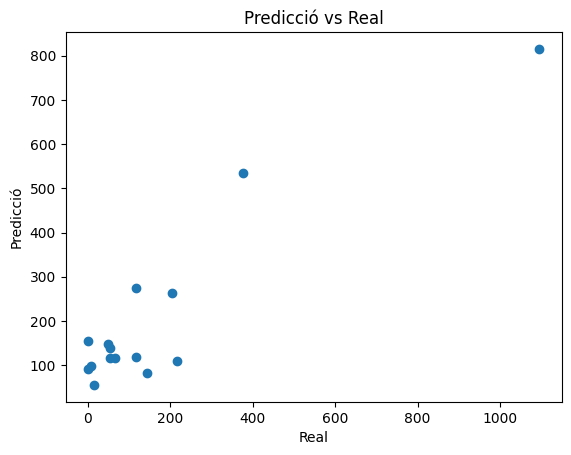

In [43]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

X_test = scaler.transform(X_test)
X_test_filtrat = pd.DataFrame(X_test, columns=df.drop(columns='temps_fins_reincidencia1a').columns)[coef_significatius.index]


y_test_pred = best_model.predict(X_test_filtrat)

# Calculem la mètrica MSE i R²
test_mse = mean_squared_error(y_test, y_test_pred)

print("\n--- AVALUACIÓ FINAL EN TEST ---")
print(f"MSE (Test): {test_mse:.4f}")


## plot de les prediccions
plt.scatter(y_test, y_test_pred)
plt.xlabel('Real')
plt.ylabel('Predicció')
plt.title('Predicció vs Real')
plt.show()